In [ ]:
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm import tqdm
# Add the parent directory of 'data' to the path
# sys.path.append(os.path.abspath("/home/nikola.jovisic.ivi/nj/dinov2"))
# from data.augmentations import DataAugmentationDINO

In [115]:
from typing import Iterable
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import ImageFilter, Image
import einops
import os
import matplotlib.pyplot as plt
from preprocess import keep_only_breast
import pandas as pd
from tqdm import tqdm
import torch
import random

def otsu_mask(img):
    median = np.median(img)
    _, thresh = cv2.threshold(img, median, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh


class OtsuCut(object):

    def __init__(self):
        super().__init__()

    def __process__(self, x):
        if isinstance(x, Image.Image):
            x = np.array(x)
        mask = otsu_mask(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY))
        # Convert to NumPy array if not already

        # Check if the matrix is empty or has no '1's
        if mask.size == 0 or not np.any(mask):
            return Image.fromarray(x)

        # Find the rows and columns where '1' appears
        rows = np.any(mask == 255, axis=1)
        cols = np.any(mask == 255, axis=0)

        # Find the indices of the rows and columns
        min_row, max_row = np.where(rows)[0][[0, -1]]
        min_col, max_col = np.where(cols)[0][[0, -1]]

        # Crop and return the submatrix
        x = x[min_row : max_row + 1, min_col : max_col + 1]
        img = Image.fromarray(x)
        return img

    def __call__(self, x):
        if isinstance(x, Iterable):
            return [self.__process__(im) for im in x]
        else:
            return self.__process__(x)
        
class KeepOnlyBreast(object):
    def __init__(self):
        super().__init__()


    def __process__(self, x):
        if isinstance(x, Image.Image):
            x = np.array(x)
            
        x, _ = keep_only_breast(x)
        x = einops.repeat(x, 'h w -> h w 3')
        
        x = (x // 255).astype(np.uint8)
        
        
        img = Image.fromarray(x)
        return img

    def __call__(self, x):
        if isinstance(x, Iterable):
            return [self.__process__(im) for im in x]
        else:
            return self.__process__(x)
        
class Pad(object):
    def __init__(self):
        super().__init__()
        
    def flip_if_should(self, image):
        x_center = image.shape[1] // 2
        col_sum = image.sum(axis=0)

        left_sum = np.sum(col_sum[0:x_center])
        right_sum = np.sum(col_sum[x_center:-1])
        
        print(left_sum.shape)

        if left_sum < right_sum:
            return np.fliplr(image)
        else:
            return image
        
        
    def pad(self, image, ar=1):
        image = self.flip_if_should(image)
        n_rows, n_cols = image.shape[:2]
        image_ratio = n_rows / n_cols
        if image_ratio == ar:
            return image
        if ar < image_ratio:
            new_n_cols = int(n_rows / ar)
            ret_val = np.zeros((n_rows, new_n_cols, image.shape[2]), dtype=image.dtype)
        else:
            new_n_rows = int(n_cols * ar)
            ret_val = np.zeros((new_n_rows, n_cols, image.shape[2]), dtype=image.dtype)
        ret_val[:n_rows, :n_cols] = image
        return ret_val


    def __process__(self, x):
        if isinstance(x, Image.Image):
            x = np.array(x)
            
        x = self.pad(x)
        
        img = Image.fromarray(x)
        return img

    def __call__(self, x):
        if isinstance(x, Iterable):
            return [self.__process__(im) for im in x]
        else:
            return self.__process__(x)
        
class Transform(object):
    def __init__(
        self, is_train: bool = True, img_size: int = 518
    ):
        self.data_transforms = transforms.Compose(
            [
                KeepOnlyBreast(),
                OtsuCut(),
                Pad(),
#                 transforms.Resize((img_size, img_size)),
#                 transforms.ToTensor(),
#                 transforms.Normalize([0.118, 0.118, 0.118], [0.1775, 0.1775, 0.1775]),
            ]
        )

    def __call__(self, img):
        return self.data_transforms(img)
    
class Identity(torch.nn.Module):
    def forward(self, x):
        return x
    
class GaussianBlur(transforms.RandomApply):
    """
    Apply Gaussian Blur to the PIL image.
    """

    def __init__(self, *, p: float = 0.5, radius_min: float = 0.1, radius_max: float = 2.0):
        # NOTE: torchvision is applying 1 - probability to return the original image
        keep_p = 1 - p
        transform = transforms.GaussianBlur(kernel_size=9, sigma=(radius_min, radius_max))
        super().__init__(transforms=[transform], p=keep_p)
        
class CustomRandomCrop:
    def __init__(self, size, scale=(0.08, 1.0), interpolation=transforms.InterpolationMode.BICUBIC, threshold=0.2, max_tries=10):
        self.size = size
        self.scale = scale
        self.interpolation = interpolation
        self.threshold = threshold
        self.max_tries = max_tries

    def __call__(self, img):
        for _ in range(self.max_tries):
            crop = transforms.RandomResizedCrop(self.size, scale=self.scale, interpolation=self.interpolation)(img)
            if np.average(np.array(crop)) / 255 > self.threshold:
                print(np.max(crop))
                print(np.min(crop))
                return crop
        return crop

    
class DataAugmentationDINO(object):
    def __init__(
        self,
        global_crops_scale,
        local_crops_scale,
        local_crops_number,
        global_crops_size=(518, 518),
        local_crops_size=96,
    ):
        self.global_crops_scale = global_crops_scale
        self.local_crops_scale = local_crops_scale
        self.local_crops_number = local_crops_number
        self.global_crops_size = global_crops_size
        self.local_crops_size = local_crops_size

        # random resized crop and flip
        self.geometric_augmentation_global = transforms.Compose(
            [
                CustomRandomCrop(
                    global_crops_size, scale=global_crops_scale
                ),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5)
            ]
        )

        self.geometric_augmentation_local = transforms.Compose(
            [
                CustomRandomCrop(
                    local_crops_size, scale=local_crops_scale
                ),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5)
            ]
        )

        # color distorsions / blurring
        color_jittering = transforms.Compose(
            [
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.0)],
                    p=0.8,
                ),
                #transforms.RandomGrayscale(p=0.2),
            ]
        )

        global_transfo1_extra = GaussianBlur(p=1.0)

        global_transfo2_extra = transforms.Compose(
            [
                GaussianBlur(p=0.1),
                transforms.RandomSolarize(threshold=128, p=0.2),
            ]
        )

        local_transfo_extra = GaussianBlur(p=0.5)

        # normalization
        self.normalize = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.118, 0.118, 0.118], [0.1775, 0.1775, 0.1775]),
            ]
        )

        self.global_transfo1 = transforms.Compose([color_jittering, global_transfo1_extra, self.normalize])
        self.global_transfo2 = transforms.Compose([color_jittering, global_transfo2_extra, self.normalize])
        self.local_transfo = transforms.Compose([color_jittering, local_transfo_extra, self.normalize])

    def __call__(self, image):
        output = {}

        # global crops:
        im1_base = self.geometric_augmentation_global(image)
        global_crop_1 = self.global_transfo1(im1_base)

        im2_base = self.geometric_augmentation_global(image)
        global_crop_2 = self.global_transfo2(im2_base)

        output["global_crops"] = [global_crop_1, global_crop_2]

        # global crops for teacher:
        output["global_crops_teacher"] = [global_crop_1, global_crop_2]

        # local crops:
        local_crops = [
            self.local_transfo(self.geometric_augmentation_local(image)) for _ in range(self.local_crops_number)
        ]
        output["local_crops"] = local_crops
        output["offsets"] = ()

        return output

/tmp/ipykernel_231/4279610273.py:1: DtypeWarning: Columns (26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train.csv')
  0%|          | 0/218598 [00:00<?, ?it/s]

()
248
0
213
24
184
29
163
47


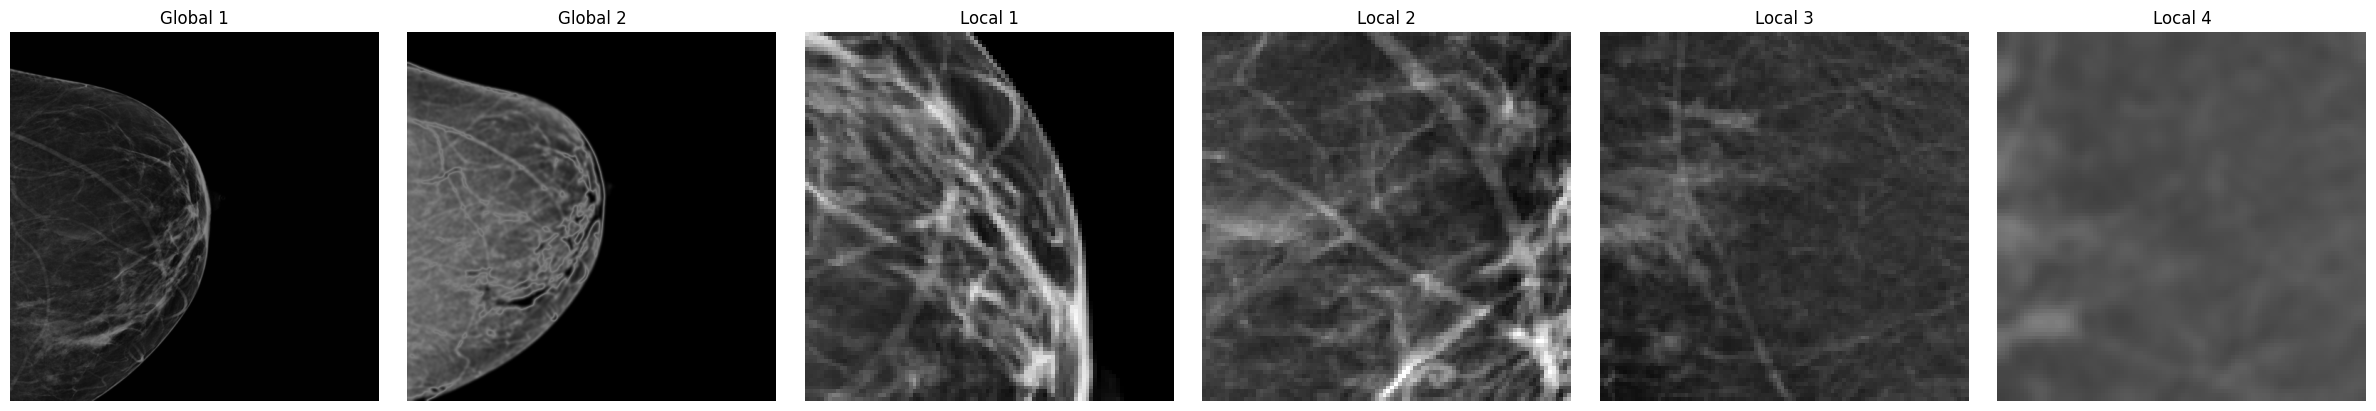

  0%|          | 1/218598 [00:03<208:19:40,  3.43s/it]

()
175
27
208
18
204
0
210
13


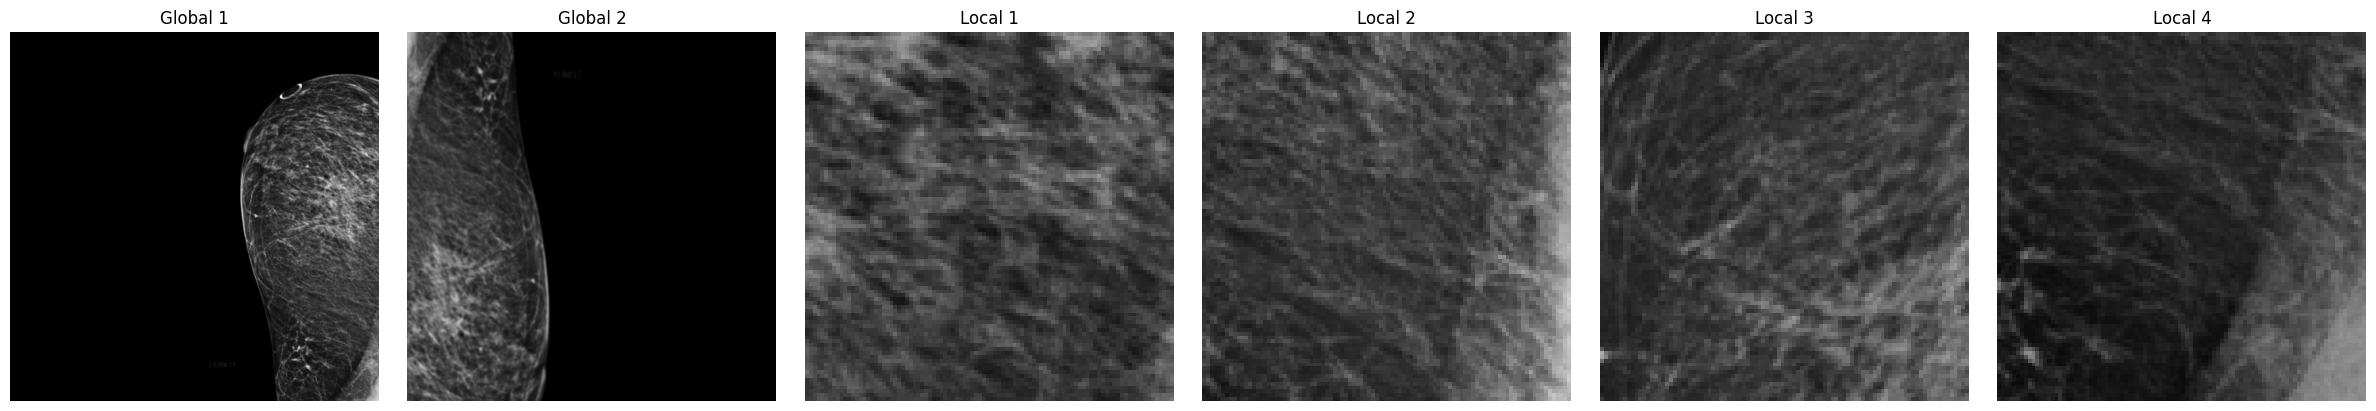

  0%|          | 2/218598 [00:06<198:03:11,  3.26s/it]

()
169
9
176
15
214
0
175
22


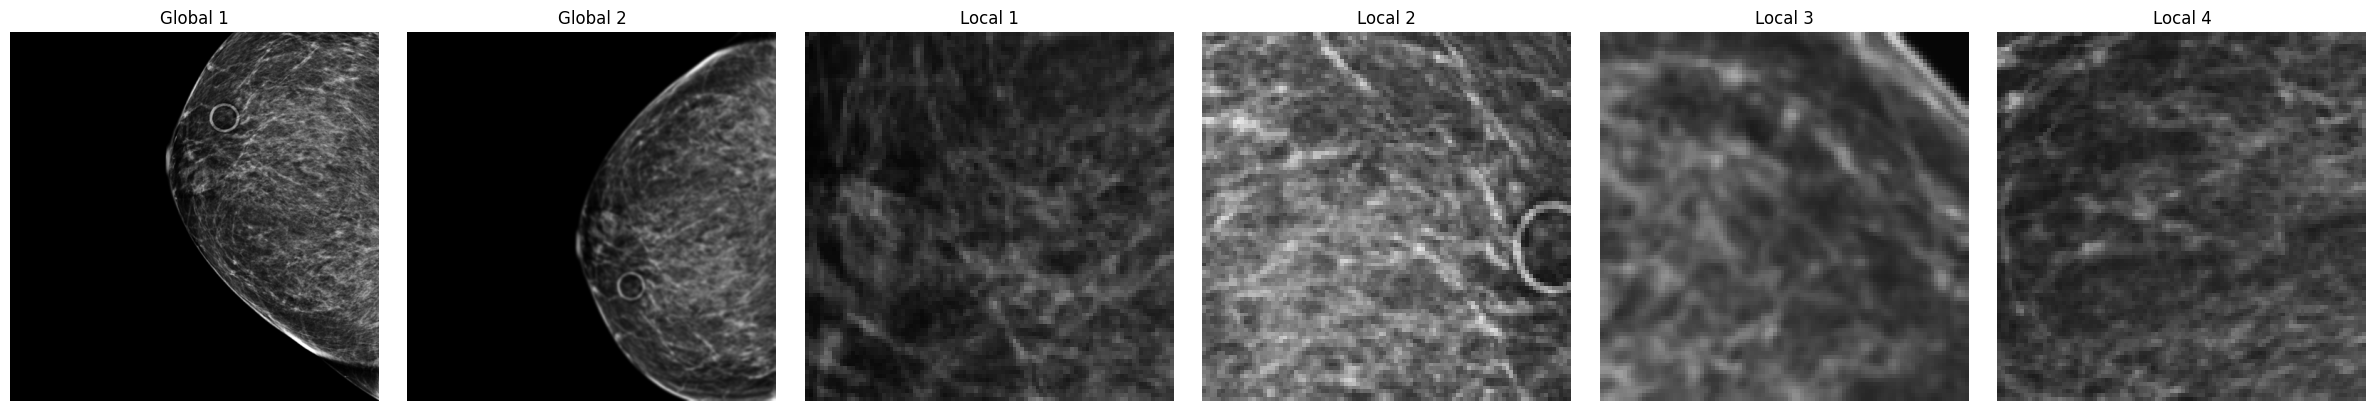

  0%|          | 3/218598 [00:09<176:46:52,  2.91s/it]

()
192
27
191
27
154
24
210
20


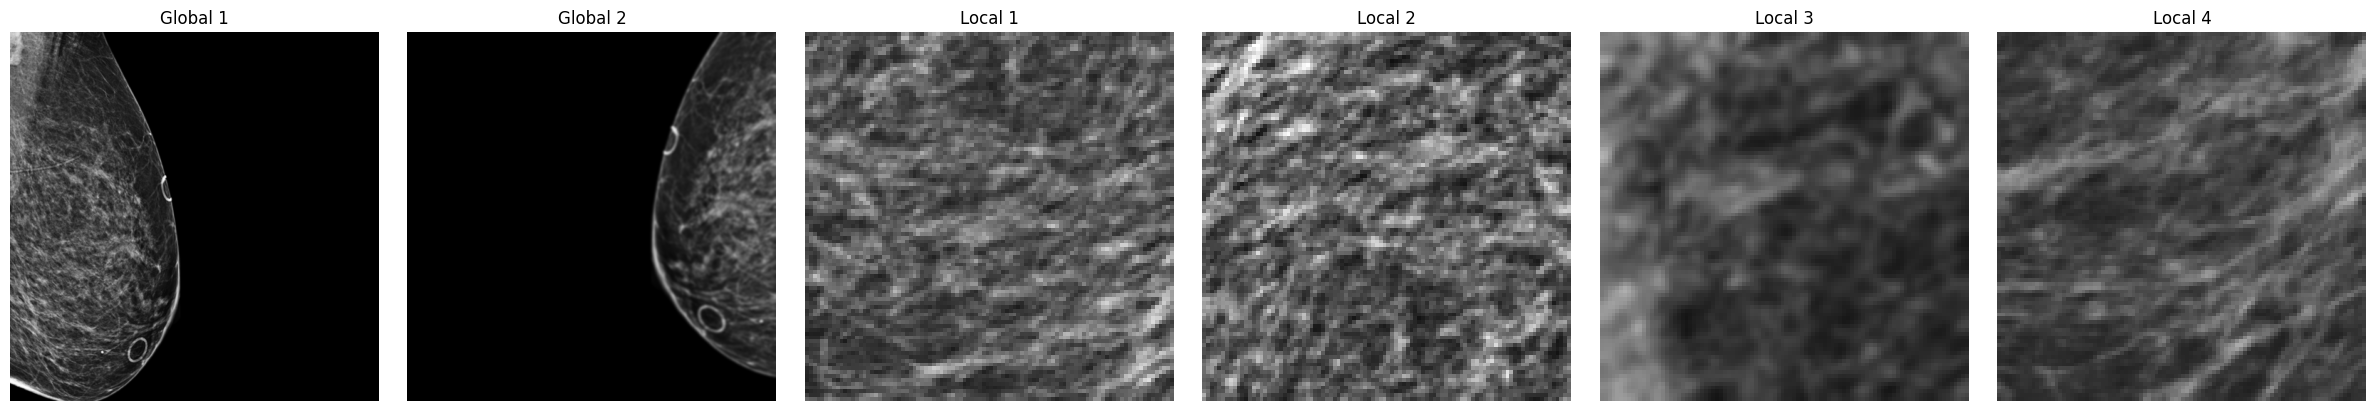

  0%|          | 4/218598 [00:12<182:49:30,  3.01s/it]

()
198
23
176
25
228
0
255
0


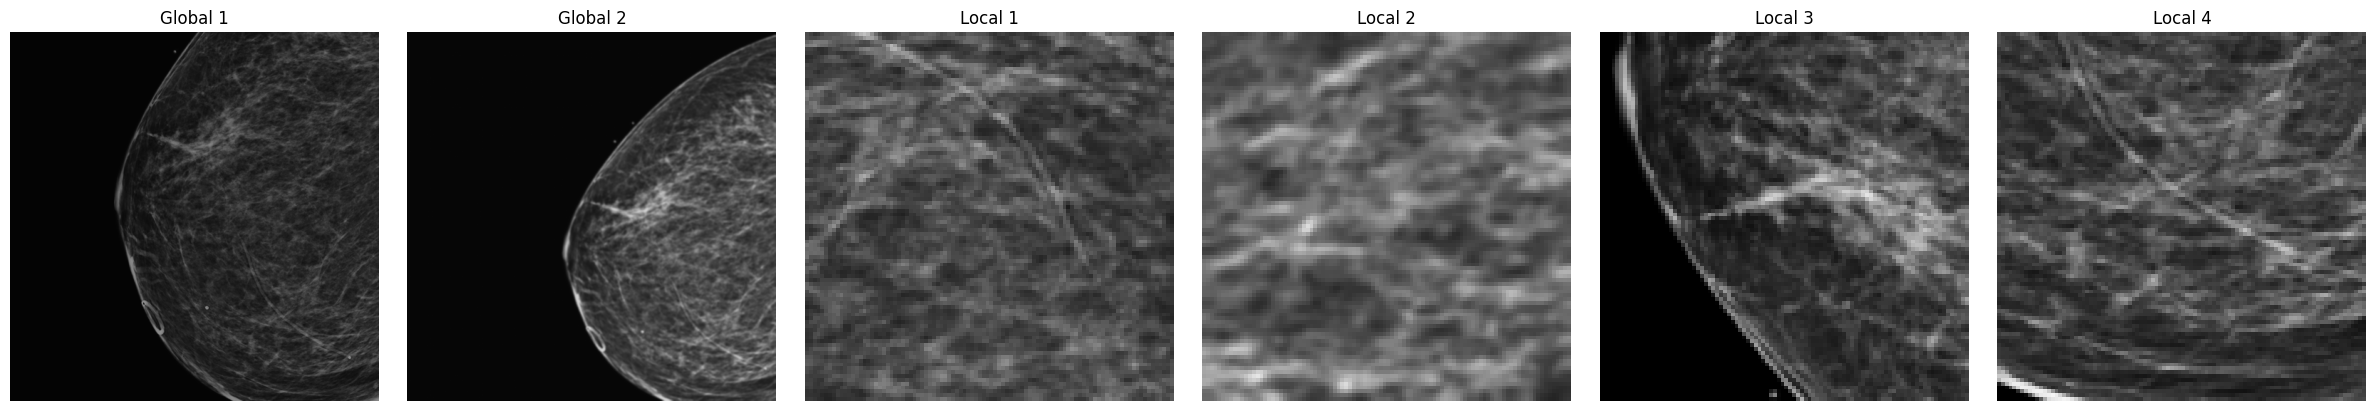

  0%|          | 5/218598 [00:14<171:59:23,  2.83s/it]

()
199
13
227
0
252
0
244
0


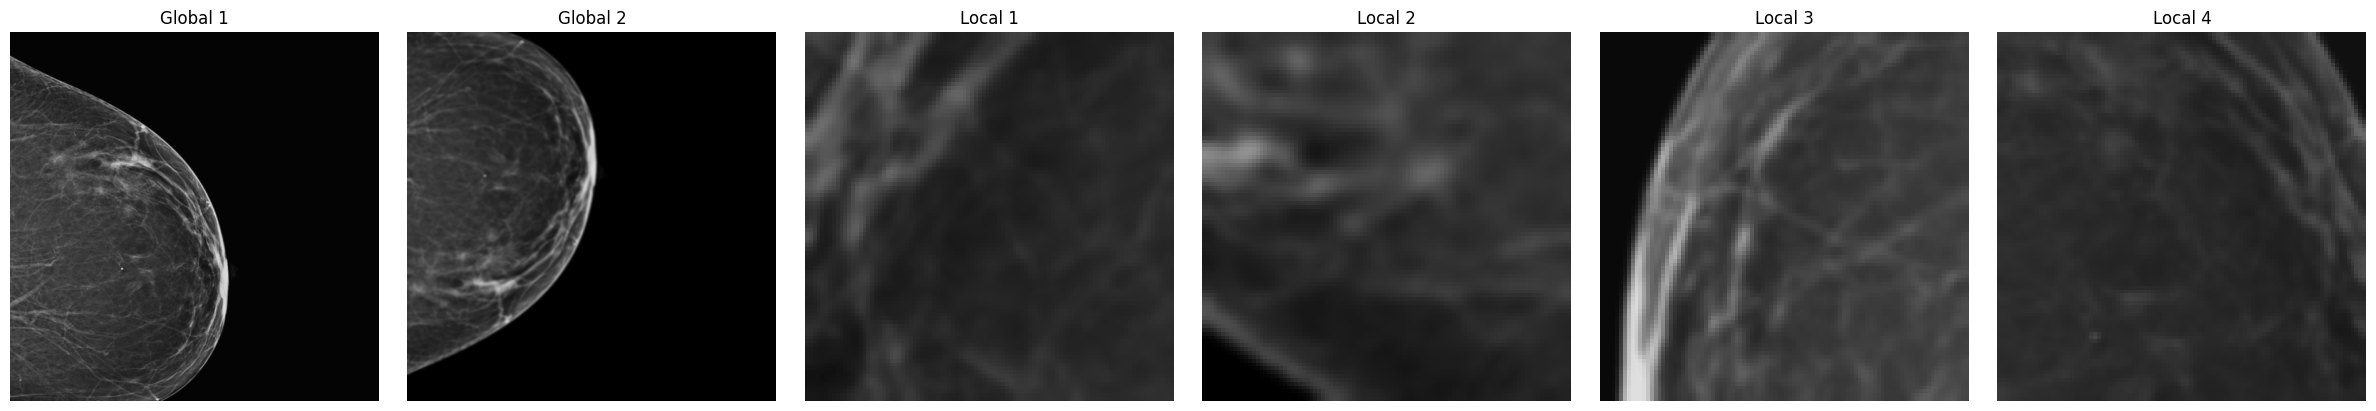

  0%|          | 6/218598 [00:17<170:18:24,  2.80s/it]

()
248
0
193
38
199
47
170
0


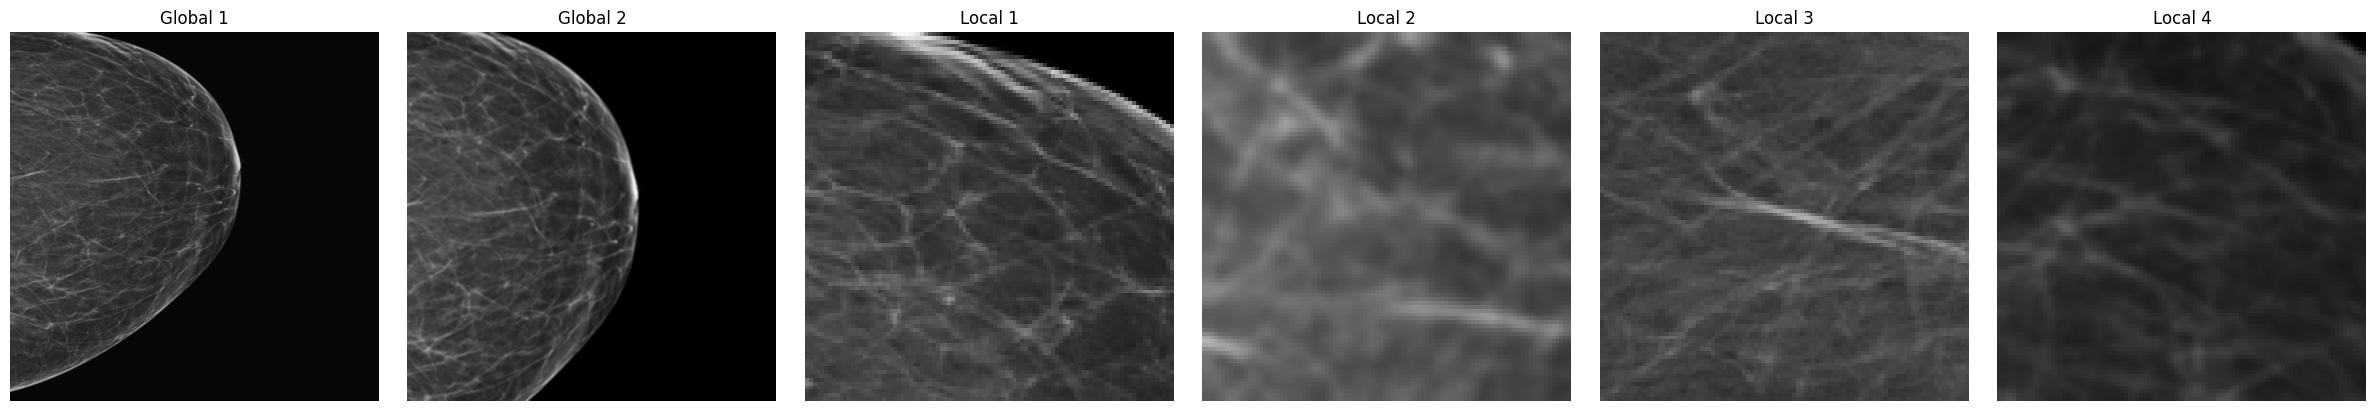

  0%|          | 7/218598 [00:20<169:42:50,  2.80s/it]

()


  0%|          | 7/218598 [00:22<192:40:16,  3.17s/it]


KeyboardInterrupt: 

In [116]:
df = pd.read_csv('train.csv')

transform = transforms.Compose(
            [
                Transform(),
                DataAugmentationDINO(global_crops_scale=(0.5, 1.0), local_crops_scale=(0.01, 0.1), local_crops_number=4)
            ]
        )

for path, label in tqdm(zip(df['png_path'], df['asses']), total=len(df)):    
    img = Image.open('/data/' + path)
    img = transform(img)

    mean = torch.tensor([0.118, 0.118, 0.118]).view(3, 1, 1)
    std = torch.tensor([0.1775, 0.1775, 0.1775]).view(3, 1, 1)

    def unnormalize(t):
        return (t * std + mean).clamp(0, 1)

    crops = img['global_crops'] + img['local_crops']
    titles = [f"Global {i+1}" for i in range(len(img['global_crops']))] + [f"Local {i+1}" for i in range(len(img['local_crops']))]

    fig, axs = plt.subplots(1, len(crops), figsize=(4 * len(crops), 4))
    for i, crop in enumerate(crops):
        crop = unnormalize(crop)
        #print(np.average(crop))
        axs[i].imshow(crop.permute(1, 2, 0))
        axs[i].set_title(titles[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
from embed_dataset import EmbedDataset

csv_path = '/home/nikola.jovisic.ivi/nj/embed/train.csv'
root = '/data'

print(dir(EmbedDataset))


